<a href="https://colab.research.google.com/github/smomtahe/BrainTumorCassification/blob/main/BrainTumorClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import files
# Choose the file from your local machine
uploaded = files.upload()

Saving MRIBrainTumor.zip to MRIBrainTumor.zip


In [8]:
import os, io, zipfile
import io
zip_file_path = '/content/MRIBrainTumor.zip'

extracted_dir = '/content/extracted_data'

!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [17]:
## List all files in the specified directory ('../content/extracted_data/Training/')
path=os.listdir('../content/extracted_data/Training/')

# Define a dictionary 'classes' to map class names to numerical labels
classes={'no_tumor':0,'pituitary_tumor':1}

In [30]:
import cv2

# Initialize empty lists to store images (X) and corresponding labels (Y)
X=[]
Y=[]
# cls no_tumor then p_tumor -> read img in 2 D and cretae a model cvm
# Loop over each class in the 'classes' dictionary
# 1st iteration the value is no tumor 2nd iteration it is tumor
for cls in classes:
  # Construct the full path for the current class
  pth='../content/extracted_data/Training/'+cls
  # Loop over each file (image) in the current class directory
  for j in os.listdir(pth): # read all of these images in a gray state
    img=cv2.imread(pth+'/'+j,0)      # Read the image in grayscale (0 means grayscale) -> img = 2DNumpy array (grayscale values of img)
    img=cv2.resize(img,(200,200))  # Resize the image to 200x200 pixels (ML need the same dimensions)
    X.append(img) # Append the image to the 'X' list
    Y.append(classes[cls])          # Append the corresponding label (numerical) to the 'Y' list

# the 'X' list will contain the resized grayscale images,
# the 'Y' list will contain corresponding numerical labels indicating the class of each image.

In [55]:
np.unique(Y) # 2 classes 0 and 1
# conver to arryay
X=np.array(X)
Y=np.array(Y)
#Y.shape
pd.Series(Y)
X.shape #1222 samples

(1222, 200, 200)

In [45]:
pd.Series(Y).value_counts()  # o positive tumor

1    827
0    395
dtype: int64

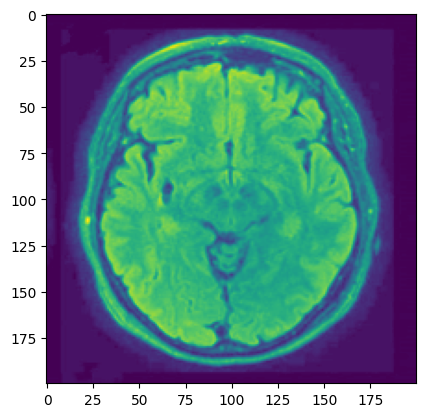

In [53]:
plt.imshow(X[200]) #imshow

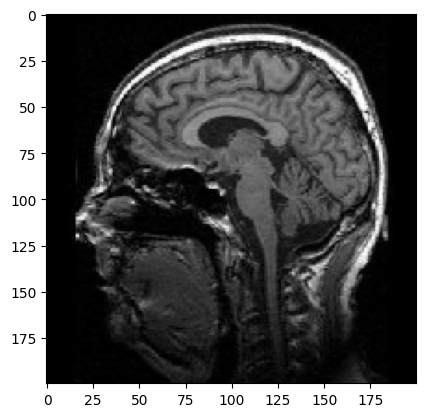

In [51]:
plt.imshow(X[0],cmap='gray')

In [56]:
# prepare data
# X 2D array (1222, 200, 200): a 3D array representing images (num_images, height, width)

X_updated=X.reshape(len(X),-1)  # Reshape X to a 2D array where each row contains all the pixel values of one image

#len : num of images #-1: size of the second dimension should be inferred
# to maintain the total number of elements: it flattens the array while keeping the number of elements unchanged.
X_updated.shape  #200*200=4000

(1222, 40000)

In [63]:
xtrain,xtest,ytrain,ytest=train_test_split(X_updated,Y,random_state=10,test_size=0.2)
xtrain.shape, xtest.shape,

((977, 40000), (245, 40000))

In [64]:
#feature scaling # all features in same scale (RGB: 0 to 255 so samples/255)
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())
xtrain=xtrain/255
xtest=xtest/255
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [65]:
#feature selection : PCA
#we want sensetive infor - delete some features - do not recommend PCA in this model
from sklearn.decomposition import PCA #not used
pca=PCA(.98)
#pca_train=pca.fit_transform(xtrain)
#pca_test=pca.transform(xtest)


In [67]:
print(xtrain.shape,xtest.shape)
pca=PCA(.98)
pca_train=xtrain #copy of it
pca_test=xtest

(977, 40000) (245, 40000)


In [74]:
# TRain Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
lg=LogisticRegression(C=0.1) #penalty parameter C
lg.fit(pca_train,ytrain)

sv=SVC()
sv.fit(pca_train,ytrain)
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
# Evaluation
print("traning score lg:" , lg.score(pca_train,ytrain)) # overfit the data
print("testing score lg:" , lg.score(pca_test,ytest))
print("traning score sv:" , sv.score(pca_train,ytrain))
print("testing score sv:" , sv.score(pca_test,ytest)) # seems better than lg

traning score lg: 1.0
testing score lg: 0.9591836734693877
traning score sv: 0.9928352098259979
testing score sv: 0.9591836734693877


In [80]:
#prediction
pred=sv.predict(pca_test)
np.where(ytest!=pred) # here the predcted and actual are not same -> misclassified

(array([ 20,  35,  60, 153, 159, 195, 220, 226, 232, 236]),)

In [83]:
ytest[20]

0

In [81]:
pred[20] #misclassified

1

In [89]:
# Test Model
dec={0:'No tumor', 1:'Positive tumor'}

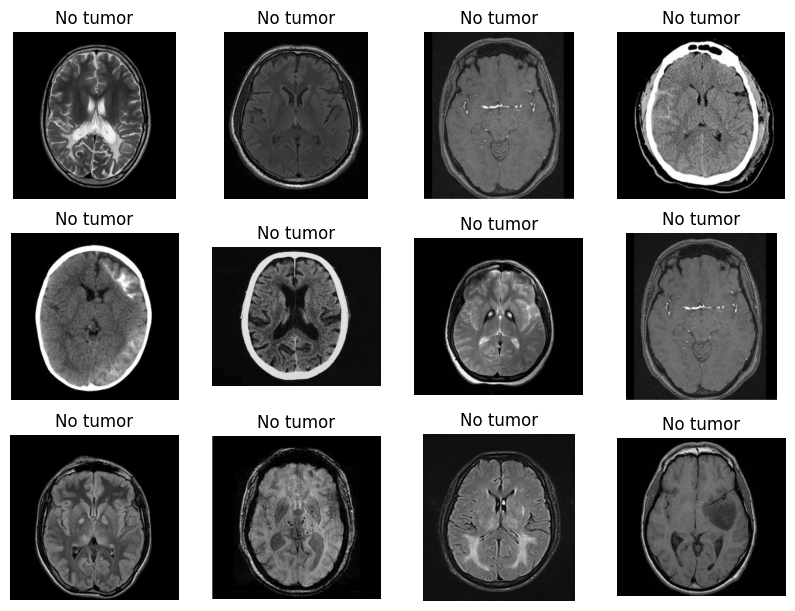

In [97]:
plt.figure(figsize=(10,10))
p=os.listdir('../content/extracted_data/Testing/')  # no tumor
c=1
for i in os.listdir('../content/extracted_data/Testing/no_tumor/')[:12]:
  plt.subplot(4,4,c)
  img=cv2.imread('../content/extracted_data/Testing/no_tumor/'+i,0)
  img1=cv2.resize(img,(200,200))
  img1=img1.reshape(1,-1)/255  # rows and 40000 columns (same as before) tehn feature scaling
  p=sv.predict(img1)
  plt.title(dec[p[0]])  # 0 : no tumor (dictionary) -> title
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  c+=1


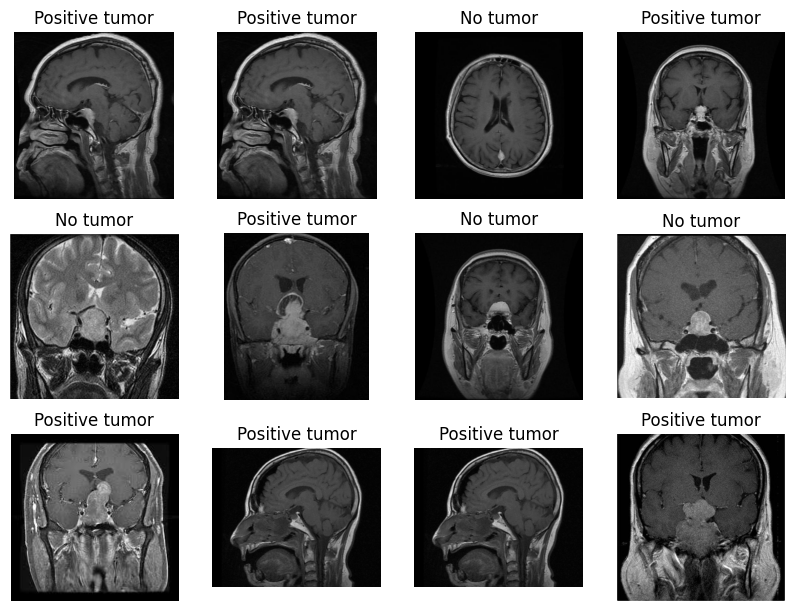

In [104]:
plt.figure(figsize=(10,10))
p=os.listdir('../content/extracted_data/Testing/')  # no tumor
c=1
for i in os.listdir('../content/extracted_data/Testing/pituitary_tumor/')[7:19]:
  plt.subplot(4,4,c)
  img=cv2.imread('../content/extracted_data/Testing/pituitary_tumor/'+i,0)
  img1=cv2.resize(img,(200,200))
  img1=img1.reshape(1,-1)/255  # rows and 40000 columns (same as before) tehn feature scaling
  p=sv.predict(img1)
  plt.title(dec[p[0]])
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  c+=1
# some misclassified!